### This file makes a shapefile from the stations from stationAttr72.csv.  It also maps those points according to their trend and buffers them to download SRTM DEMs

In [45]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from shapely.geometry import Point
from pathlib import Path
from scipy import stats
import contextily as ctx
import mplleaflet
import fiona
import elevation
import rasterio
from rasterio.transform import from_bounds, from_origin
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
from rasterio.merge import merge
import glob
#import earthpy as et
import seaborn as sns
# Prettier plotting with seaborn
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
from netCDF4 import Dataset

In [46]:
#change directory to the data_light directory
os.chdir(os.path.join(str(Path.home()),
                      "Documents/research/wind/globalWindTrends/data_light"))

In [47]:
#Here we can switch the datasets
df=pd.read_csv('meanPrevail90.csv')
df.head(),df.shape

(  stationNumber     slope  lowBound  hightBound  slopeInt   meanWind  mw1990  \
 0  239290-99999  0.098522 -0.028054    0.225099         0  26.928571    30.0   
 1  485680-99999  0.061576 -0.162410    0.285563         0  18.464286    26.0   
 2  916970-99999 -0.726601 -1.151272   -0.301930        -1  27.321429    24.0   
 3  917530-99999 -0.180624 -0.280164   -0.081084        -1  36.500000    42.0   
 4  601270-99999  0.148878  0.021917    0.275839         1  13.714286    11.0   
 
    mw2017  pw1990  pw2017  pwDiff  
 0    30.0   227.0   228.0     1.0  
 1    22.0    94.0    81.0    13.0  
 2     1.0   117.0   120.0     3.0  
 3    34.0   108.0   110.0     2.0  
 4    11.0   270.0    90.0   180.0  , (4812, 11))

In [48]:
#let's check if there are any NAN's in any of the rows
df.isnull().values.any()

True

In [49]:
#check to see where the null values are
df.isnull().sum()

stationNumber     0
slope            63
lowBound         63
hightBound       63
slopeInt          0
meanWind          0
mw1990           12
mw2017           12
pw1990           12
pw2017           12
pwDiff           24
dtype: int64

In [50]:
#since there are some null values, we will drop the row(s) with null values
df = df.dropna()
#pandas does not reset index where drop takes place
df.reset_index(drop=True, inplace=True)

df.shape

(4749, 11)

In [51]:
#Need to add some attributes from ID_Info.csv
df_id = pd.read_csv("ID_Info.csv")
df_id.head()

,ID,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,Timespan
0,008268-99999,8268,99999,WXPOD8278,AF,NaN,NaN,32.950,65.567,1156.7,2010-05-19,2012-03-23,674
1,010010-99999,10010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9.0,1931-01-01,2017-05-22,31553
2,010014-99999,10014,99999,SORSTOKKEN,NO,NaN,ENSO,59.792,5.341,48.8,1986-11-20,2017-05-22,11141
3,010015-99999,10015,99999,BRINGELAND,NO,NaN,NaN,61.383,5.867,327.0,1987-01-17,2011-10-20,9042
4,010016-99999,10016,99999,RORVIK/RYUM,NO,NaN,NaN,64.850,11.233,14.0,1987-01-16,1991-08-06,1663


In [52]:
#add the columns that we will get from ID_Info.csv to df
df["elev"] = np.nan
df["lat"] = np.nan
df["lon"] = np.nan
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,meanWind,mw1990,mw2017,pw1990,pw2017,pwDiff,elev,lat,lon
0,239290-99999,0.098522,-0.028054,0.225099,0,26.928571,30.0,30.0,227.0,228.0,1.0,NaN,NaN,NaN
1,485680-99999,0.061576,-0.162410,0.285563,0,18.464286,26.0,22.0,94.0,81.0,13.0,NaN,NaN,NaN
2,916970-99999,-0.726601,-1.151272,-0.301930,-1,27.321429,24.0,1.0,117.0,120.0,3.0,NaN,NaN,NaN
3,917530-99999,-0.180624,-0.280164,-0.081084,-1,36.500000,42.0,34.0,108.0,110.0,2.0,NaN,NaN,NaN
4,601270-99999,0.148878,0.021917,0.275839,1,13.714286,11.0,11.0,270.0,90.0,180.0,NaN,NaN,NaN


In [53]:
#fill in the new columns with info from ID_Info.csv
nr = df.shape[0]
for i in range(nr):
    sn = df["stationNumber"][i]
    
    #get the index in df_id associated with that staion number
    idx = df_id.index[df_id['ID']==sn][0]
    
    df.loc[[i],['elev']] = df_id["ELEV(M)"][idx]
    df.loc[[i],['lat']] = df_id["LAT"][idx]
    df.loc[[i],['lon']] = df_id["LON"][idx]
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,meanWind,mw1990,mw2017,pw1990,pw2017,pwDiff,elev,lat,lon
0,239290-99999,0.098522,-0.028054,0.225099,0,26.928571,30.0,30.0,227.0,228.0,1.0,53.0,60.317,64.217
1,485680-99999,0.061576,-0.162410,0.285563,0,18.464286,26.0,22.0,94.0,81.0,13.0,3.7,7.187,100.608
2,916970-99999,-0.726601,-1.151272,-0.301930,-1,27.321429,24.0,1.0,117.0,120.0,3.0,5.0,-19.133,179.750
3,917530-99999,-0.180624,-0.280164,-0.081084,-1,36.500000,42.0,34.0,108.0,110.0,2.0,24.1,-13.238,-176.199
4,601270-99999,0.148878,0.021917,0.275839,1,13.714286,11.0,11.0,270.0,90.0,180.0,510.0,34.217,-4.000


In [54]:
# df.to_csv("~/Desktop/print.csv",sep=',', mode = 'a')

## Look at the distribution of mean wind speed trends

In [55]:
dfNeg = df[df['slopeInt']== -1]
dfZero = df[df['slopeInt']== 0]
dfPos = df[df['slopeInt']== 1]

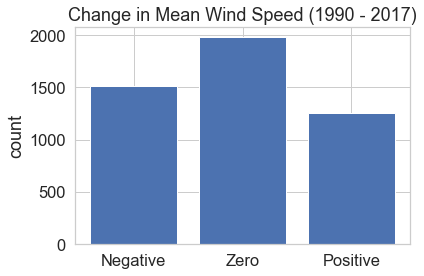

In [56]:
#plot the number of neg,zero,pos trends
x = np.arange(3)
plt.bar(x,[len(dfNeg), len(dfZero), len(dfPos)])
plt.xticks(x,("Negative","Zero", "Positive"));
plt.title("Change in Mean Wind Speed (1990 - 2017)")
plt.ylabel("count");

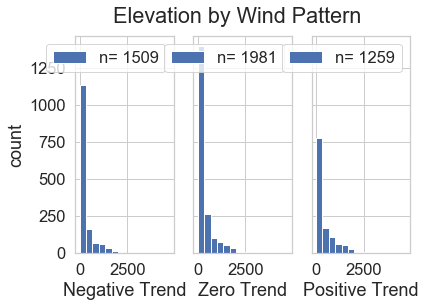

In [57]:
#Look at the elevation by change in wind speed pattern
b = np.linspace(0,max(df.elev),15)
#fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex = True);
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey = True);
ax1.hist(dfNeg["elev"],bins=b,label = "n= "+str(len(dfNeg["elev"])));
ax1.set_ylabel("count")
ax1.set_xlabel("Negative Trend")
ax1.legend()

ax2.hist(dfZero["elev"],bins=b,label = "n= "+str(len(dfZero["elev"])));
ax2.set_xlabel("Zero Trend")
ax2.legend()

ax3.hist(dfPos["elev"],bins = b,label = "n= "+str(len(dfPos["elev"])));
ax3.set_xlabel("Positive Trend")
ax3.legend()

fig.suptitle("Elevation by Wind Pattern");

In [58]:
# are these distributions different? (they don't look it...)
# we use a Kolmogorov-Smirnov test
e1 = dfNeg["elev"]
e2 = dfZero['elev']
e3 = dfPos['elev']
for dist in [e1,e2,e3]:
    for dist2 in [e1,e2,e3]:
        print(stats.ks_2samp(dist,dist2))

Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.05674684854025769, pvalue=0.0076727320372071)
Ks_2sampResult(statistic=0.15251777658118015, pvalue=2.0023649260975208e-14)
Ks_2sampResult(statistic=0.05674684854025769, pvalue=0.0076727320372071)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.12294197577542654, pvalue=1.2720577355933395e-10)
Ks_2sampResult(statistic=0.15251777658118015, pvalue=2.0023649260975208e-14)
Ks_2sampResult(statistic=0.12294197577542654, pvalue=1.2720577355933395e-10)
Ks_2sampResult(statistic=0.0, pvalue=1.0)


In [59]:
trendElevations = [dfNeg["elev"][dfNeg['elev']>=0], dfZero["elev"][dfZero['elev']>=0], dfPos["elev"][dfPos['elev']>=0]]
print("for these results:")
print("0 --> negative")
print("1 --> no change")
print("2 --> positive")
for i in range(len(trendElevations)):
    for j in range(len(trendElevations)):
        print("Restults for {} versus {}:".format(i,j))
        print(stats.ks_2samp(trendElevations[i],trendElevations[j]))
        print()
        

for these results:
0 --> negative
1 --> no change
2 --> positive
Restults for 0 versus 0:
Ks_2sampResult(statistic=0.0, pvalue=1.0)

Restults for 0 versus 1:
Ks_2sampResult(statistic=0.05481069534596883, pvalue=0.011383287690955632)

Restults for 0 versus 2:
Ks_2sampResult(statistic=0.15393010263739115, pvalue=1.2446943357589847e-14)

Restults for 1 versus 0:
Ks_2sampResult(statistic=0.05481069534596883, pvalue=0.011383287690955632)

Restults for 1 versus 1:
Ks_2sampResult(statistic=0.0, pvalue=1.0)

Restults for 1 versus 2:
Ks_2sampResult(statistic=0.12297758107813972, pvalue=1.419386577114265e-10)

Restults for 2 versus 0:
Ks_2sampResult(statistic=0.15393010263739115, pvalue=1.2446943357589847e-14)

Restults for 2 versus 1:
Ks_2sampResult(statistic=0.12297758107813972, pvalue=1.419386577114265e-10)

Restults for 2 versus 2:
Ks_2sampResult(statistic=0.0, pvalue=1.0)



In [60]:
[i.mean() for i in trendElevations]

[296.6822591362126, 348.42524123920776, 477.52976855546694]

In [61]:
[i.median() for i in trendElevations]

[115.0, 113.0, 200.0]

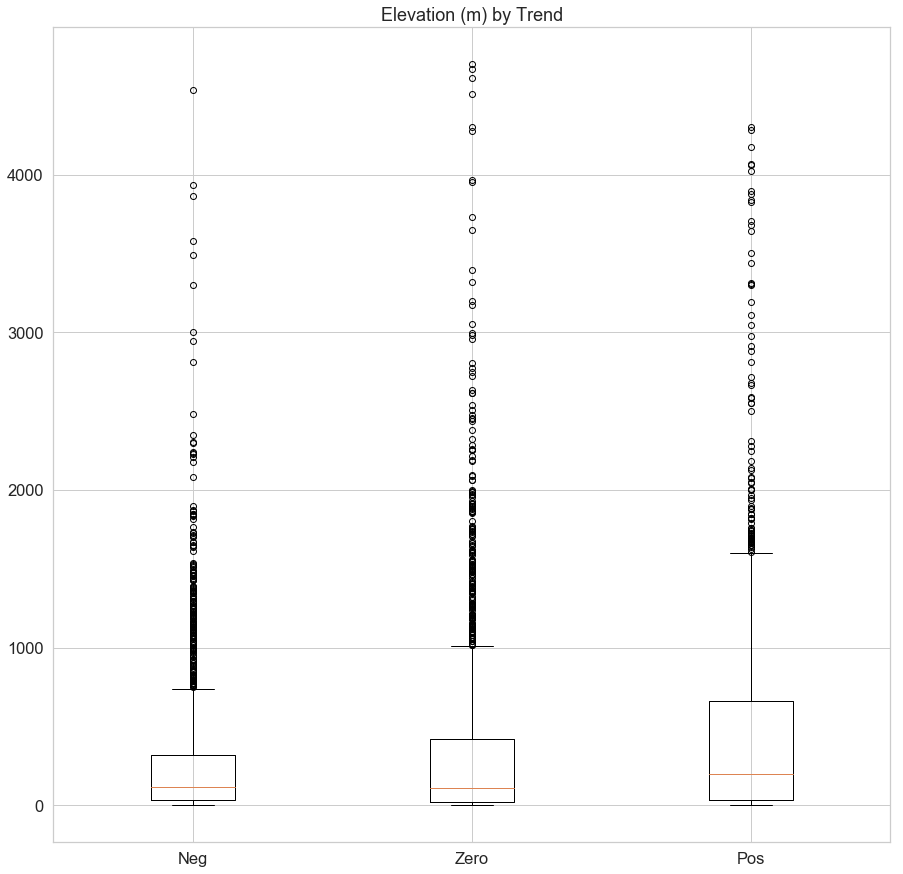

In [62]:
labels = ["Neg","Zero","Pos"]
fig,ax = plt.subplots(figsize=(15,15))
ax.boxplot(trendElevations);
ax.set_xticklabels(labels);
ax.set_title("Elevation (m) by Trend");
# plt.savefig(pcFolder+"boxplot.png")

## Plotting the points

In [63]:
# A GeoDataFrame needs a shapely object, so we create a new 
#column 'coordinates' as a tuple of 'lat' and 'lon'
df['coordinates'] = list(zip(df.lon, df.lat)) #(x,y ==> lon,lat)

#transform tuples to Point
df['coordinates'] = df['coordinates'].apply(Point)

#now we can create the GeoDataFrame by setting geometry with 
#previosly created coordinates
gdf = gpd.GeoDataFrame(df,geometry= 'coordinates')

In [64]:
#Need to set the coordinate system (epsg:4269 = NAD83 datum) 
#3857 = pseudo-mercator
gdf.crs = {'init' :'epsg:4269'}
gdf = gdf.to_crs({'init' :'epsg:3857'}) #switch to pseudo-mercator 

In [65]:
#we need to add a string column that represents slopeInt for better
#plotting
def createString(gdf):
    if gdf["slopeInt"] == -1:
        return "Negative"
    elif gdf["slopeInt"] ==0:
        return "Zero"
    elif gdf["slopeInt"]==1:
        return "Positive"
    else:
        return "Big trouble in little china!"
gdf['trend'] = gdf.apply(createString, axis = 1)
gdf.head(2)

,stationNumber,slope,lowBound,hightBound,slopeInt,meanWind,mw1990,mw2017,pw1990,pw2017,pwDiff,elev,lat,lon,coordinates,trend
0,239290-99999,0.098522,-0.028054,0.225099,0,26.928571,30.0,30.0,227.0,228.0,1.0,53.0,60.317,64.217,POINT (7148603.740271651 8470655.151552135),Zero
1,485680-99999,0.061576,-0.162410,0.285563,0,18.464286,26.0,22.0,94.0,81.0,13.0,3.7,7.187,100.608,POINT (11199631.32972967 802159.5298121886),Zero


In [66]:
# Create a dictionary where you assign each attribute value to a particular color
trendPalette = {"Negative": 'b',
               "Positive": 'r',
               "Zero": 'grey'}

In [67]:
#Read in the world shapefile and set to gdf.crs
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name != "Antarctica")]
world = world.to_crs(gdf.crs)
world.crs, gdf.crs

({'init': 'epsg:3857'}, {'init': 'epsg:3857'})

In [68]:
pcFolder = "/Users/andymetcalf/Documents/research/wind/ForChrisAndPeter/"

Negative
Positive
Zero


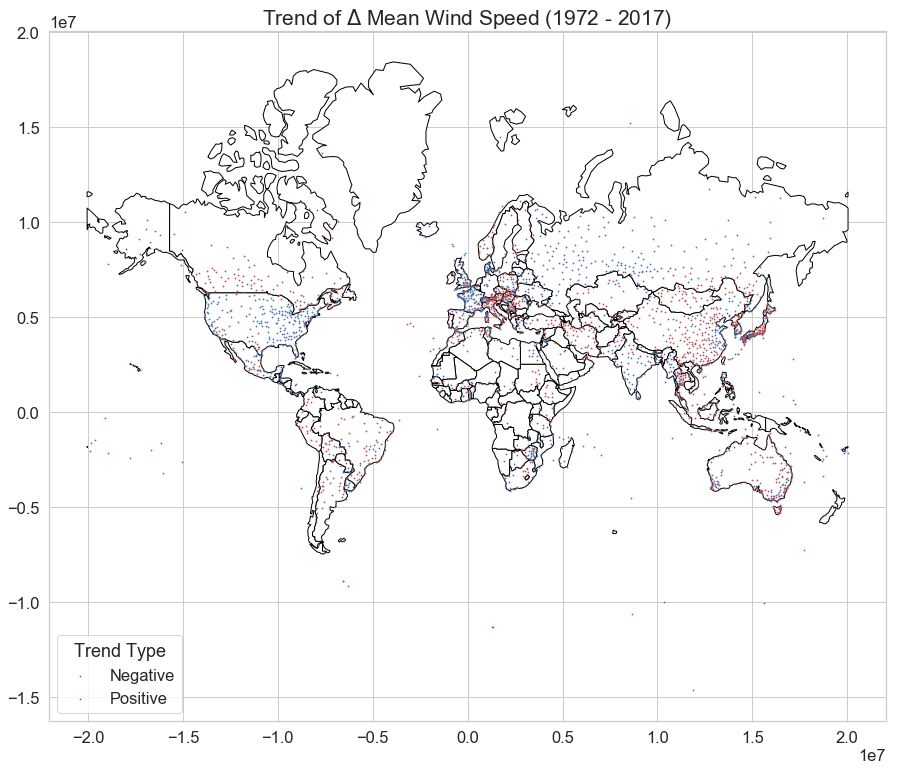

In [69]:
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)
# show(dem_raster, ax=ax)

#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    print(ctype)
    if ctype=="Zero":
        continue
        
    color = trendPalette[ctype]
    data.plot(color = color,
              markersize = 0.6,
              ax = ax,
              label = ctype)
ax.legend(title = "Trend Type",
          loc = "lower left");
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);
# plt.savefig(pcFolder+"1990.png")


## Plot an interactive version using mplleaflet

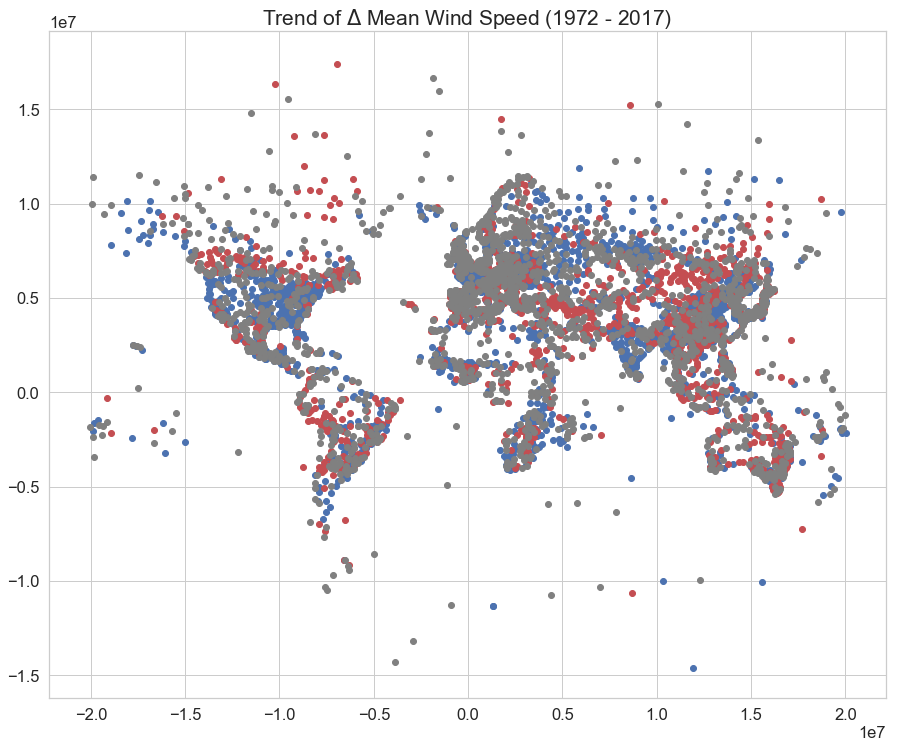

In [70]:
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype);
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);

In [71]:
# mplleaflet.display(fig=ax.figure, crs=world.crs)

In [72]:
#create a buffer around the weather stations(numbers are meters)
buffer = gdf.coordinates.buffer(1000)
#create a bounding box arund the buffer
boundBox = buffer.envelope
# gdf.head()

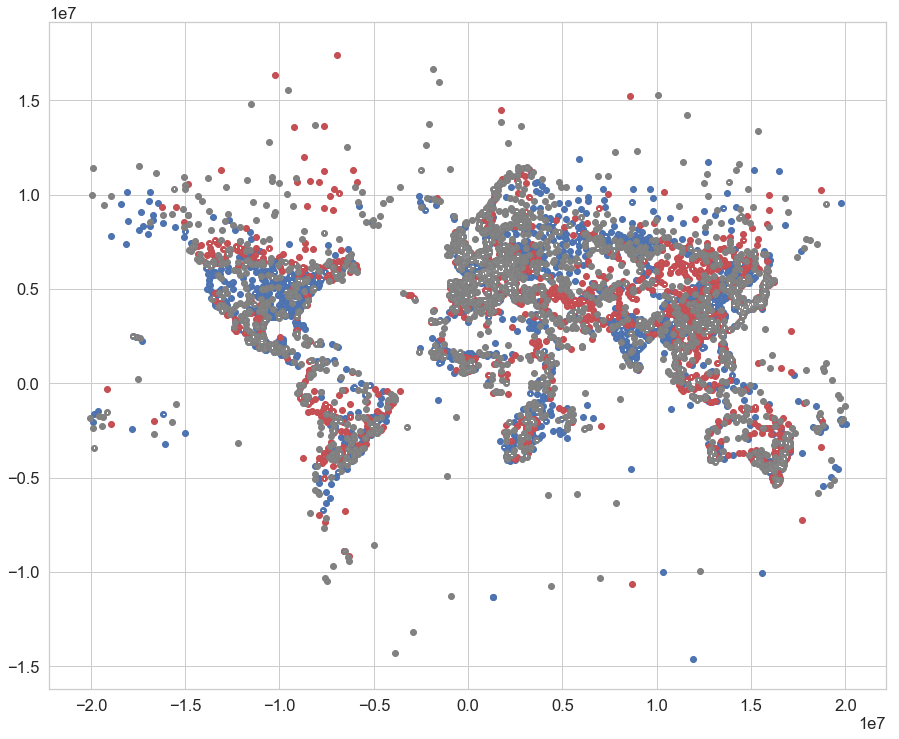

In [73]:
#plot the data with the buffer
fig,ax = plt.subplots(figsize=(15,15))
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype);
buffer.plot(ax=ax)
boundBox.plot(ax=ax)

# mplleaflet.display(fig=ax.figure, crs=world.crs)
#mplleaflet.display(fig=ax.figure, crs=world.crs,tiles='esri_aerial')

In [74]:
type(buffer)

geopandas.geoseries.GeoSeries

In [75]:
#create geodataframe with buffer
demGDF = gpd.GeoDataFrame(buffer,
                          columns = ['geometry'],
                          crs = gdf.crs)

In [76]:
demGDF["stationNumber"] = gdf["stationNumber"]

In [77]:
demGDF.head()

,geometry,stationNumber
0,"POLYGON ((7149603.740271651 8470655.151552135,...",239290-99999
1,"POLYGON ((11200631.32972967 802159.5298121886,...",485680-99999
2,POLYGON ((20010678.47009093 -2170600.785084128...,916970-99999
3,POLYGON ((-19613382.95828401 -1486936.33737582...,917530-99999
4,POLYGON ((-444277.9631730949 4057977.175470298...,601270-99999


In [78]:
#convert dataframe to WGS84 to use the elevation package for automated
#SRTM DEM extraction
demGDF_WGS84 = demGDF.to_crs({'init' :'epsg:4326'})
demGDF_WGS84.crs, demGDF.crs

({'init': 'epsg:4326'}, {'init': 'epsg:3857'})

In [79]:
os.getcwd()

'/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light'

## Code to write geodataframes to shape files (Uncomment for use)

In [80]:
# #code to write geodatabases to shape files
# outPathPoints = os.getcwd()+"/outputShapefiles/stationPoints90.shp"
# outPathBuffer = os.getcwd()+"/outputShapefiles/stationBuffer90_1k.shp"

# gdf.to_file(outPathPoints)
# demGDF.to_file(outPathBuffer)

## Code block below if for bulk download of SRTM DEM
## Uncomment for usage

In [81]:
# #Download all of the .tif files from the SRTM DEM
# nr = demGDF_WGS84.shape[0]
# for i in range(nr):
#     #get the bounds of the buffer
#     bounds = tuple(demGDF_WGS84.loc[[i],["geometry"]].bounds.values[0])
#     stNum = demGDF_WGS84.loc[[i],["stationNumber"]].values[0][0]
#     outputPath = os.getcwd()+"/1kTiff/"+stNum+"_1k.tif"
#     #call to the elevation package
#     #SRTM1 is the 30m resolution set
#     elevation.clip(bounds = bounds, output = outputPath, product = 'SRTM1')

# Here we get a sample of the geodataframe with the 20 highest and lowest wind declines.  We also open the new shapefile with the distance to oceans feature

In [340]:
#open the shapefile that has the distance to the ocean parameter
gdf = gpd.read_file("/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/outputShapefiles/stationPoints90_proximityToOcean.shp")

In [361]:
gdf.head(3),gdf.shape

(  stationNumber     slope  lowBound  hightBound  slopeInt   meanWind  pw1990  \
 0  561520-99999  0.172687  0.085855    0.259520         1  20.750000   303.0   
 1  802340-99999 -0.072797 -0.184288    0.038694         0   7.857143    91.0   
 2  010520-99999 -0.053640 -0.148235    0.040955         0  46.928571   204.0   
 
    pw2017    elev     lat      lon  \
 0   301.0  3896.0  32.283  100.333   
 1    59.0   424.9   4.168  -73.614   
 2   230.0    81.0  70.683   23.683   
 
                                     coordinates     trend  
 0   POINT (11169018.46976151 3800516.371680081)  Positive  
 1  POINT (-8194672.995256038 464389.4007512619)      Zero  
 2   POINT (2636379.500457099 11294743.37457483)      Zero  , (4749, 13))

In [362]:
#sort the dataframe
gdfSorted = gdf.sort_values(by=['slope'])
gdfSorted.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,meanWind,pw1990,pw2017,elev,lat,lon,coordinates,trend
3259,895920-99999,-7.772304,-9.446498,-6.098111,-1,113.785714,115.0,131.0,40.0,-66.550,93.017,POINT (10354605.07511793 -10029023.86133978),Negative
1735,429700-99999,-4.965791,-11.588359,1.656777,0,212.678571,29.0,174.0,27.0,20.467,85.933,POINT (9566017.802338373 2328436.325430165),Zero
1310,895120-99999,-4.287356,-5.989737,-2.584976,-1,138.428571,135.0,136.0,119.0,-70.767,11.833,POINT (1317243.534556807 -11323070.48609801),Negative
697,424980-99999,-4.181445,-7.148591,-1.214299,-1,39.464286,25.0,83.0,49.0,25.233,86.950,POINT (9679229.724475136 2904390.672588008),Negative
2403,890500-99999,-3.382047,-4.568177,-2.195917,-1,91.428571,329.0,298.0,14.0,-62.183,-58.883,POINT (-6554825.576380328 -8902666.060718747),Negative


In [363]:
#exclude those with hight variability, i.e., those with zero trend
gdfSorted = gdfSorted[gdfSorted['trend']!="Zero"]
#exclude antarctica and far north
gdfSorted = gdfSorted[(gdfSorted['lat']>-56)&(gdfSorted['lat']<71)]
gdfSorted.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,meanWind,pw1990,pw2017,elev,lat,lon,coordinates,trend
697,424980-99999,-4.181445,-7.148591,-1.214299,-1,39.464286,25.0,83.0,49.0,25.233,86.950,POINT (9679229.724475136 2904390.672588008),Negative
3031,060090-99999,-2.489600,-3.993700,-0.985501,-1,92.821429,243.0,0.0,102.0,61.400,-6.667,POINT (-742167.0451187564 8718253.185613055),Negative
2089,434970-99999,-2.353038,-2.744649,-1.961427,-1,52.928571,59.0,241.0,20.0,6.117,81.133,POINT (9031684.246530663 682238.5940661161),Negative
1015,766913-99999,-2.048714,-2.609644,-1.487784,-1,41.714286,34.0,19.0,27.4,19.146,-96.187,POINT (-10707487.86093261 2172132.613173377),Negative
2580,689200-99999,-1.911604,-2.321692,-1.501515,-1,54.535714,211.0,248.0,14.0,-34.833,20.017,POINT (2228282.247208957 -4141209.606175919),Negative


In [364]:
#get the population mean
popMean = gdf["NEAR_DIST"].mean()

nList=[]
pList=[]
means=[]
randMeans = []
for i in range(10,2000):
    NegSamp = gdfSorted[0:i]
    PosSamp = gdfSorted[-i-1:-1]
    sampSize = len(PosSamp)
    #get the distance to the ocean for the samples that were just taken
    negSampDistance = NegSamp["NEAR_DIST"].values
    posSampDistance = PosSamp["NEAR_DIST"].values
    sampDistance = np.concatenate((negSampDistance,posSampDistance))
    nsamp = len(sampDistance)
    sampMean = sampDistance.mean()
    randSamp = gdf["NEAR_DIST"].sample(n=nsamp)
    randSampMean = randSamp.mean()
    randMeans.append(randSampMean)
    means.append(sampMean)
    t,p = stats.ttest_1samp(sampDistance,popMean) #this is a two sample result, so we can split it in half
    pReal = p/2
    nList.append(sampSize)
    pList.append(pReal)

KeyError: 'NEAR_DIST'

Text(0.5, 1.0, '$H_0$: sample.mean(distToOcean) >= pop.mean(distToOcean)\n$H_1$: sample.mean(distToOcean) < pop.mean(distToOcean)')

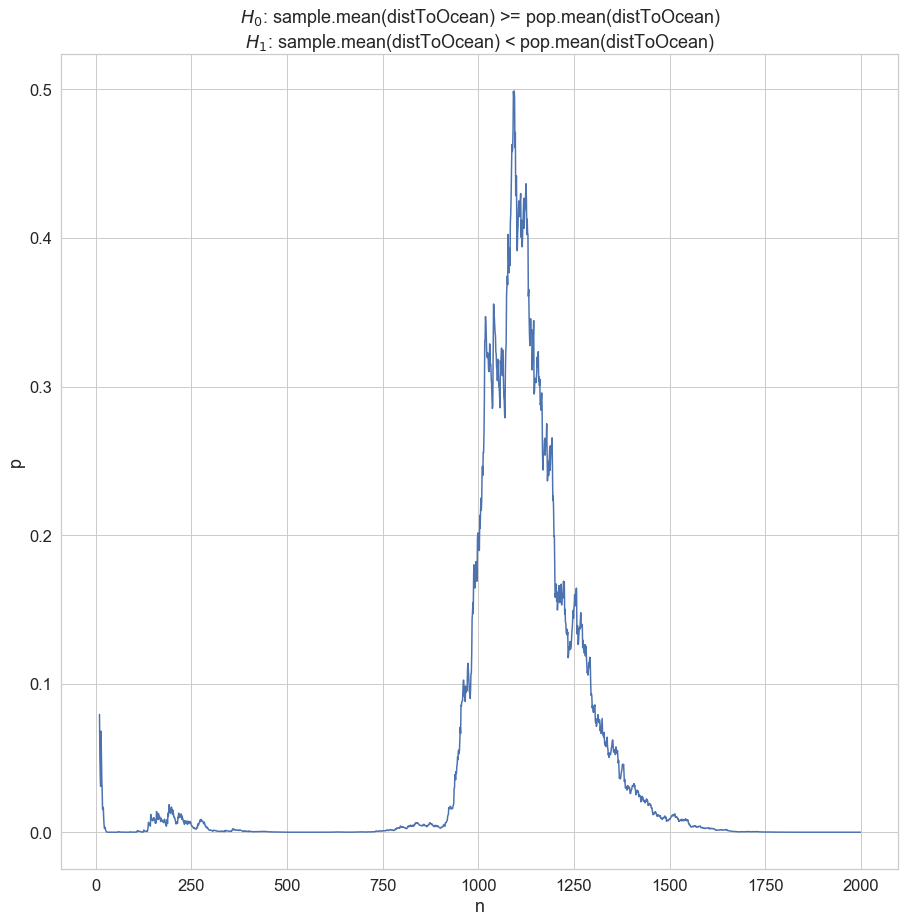

In [245]:
fig,ax = plt.subplots(figsize=(15,15))
ax.plot(nList,pList)
ax.set_xlabel("n")
ax.set_ylabel("p")
ax.set_title("$H_0$: sample.mean(distToOcean) >= pop.mean(distToOcean)\n$H_1$: sample.mean(distToOcean) < pop.mean(distToOcean)")
# plt.savefig(pcFolder+"tTest.png")

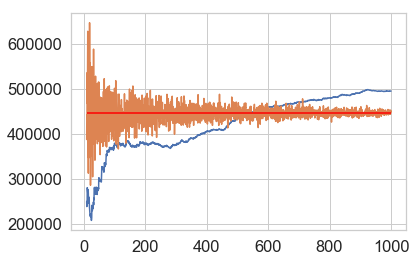

In [246]:
x = np.linspace(10,1000,len(means))
plt.plot(x,means)
# plt.plot(x,randMeans)
plt.hlines(gdf.NEAR_DIST.mean(),10,1000,'red',zorder = 10)
plt.plot(x,randMeans)

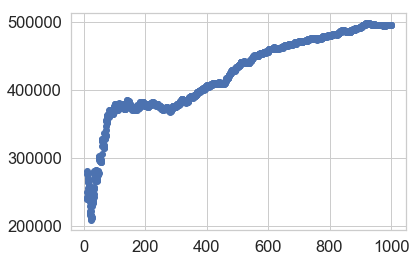

In [247]:
plt.scatter(x,means)

In [248]:
t,p = stats.ttest_ind(means,randMeans)

In [249]:
p

7.628693803830316e-55

In [191]:
len(means), len(randMeans)

(990, 990)

In [192]:
stats.mannwhitneyu(means,randMeans)

MannwhitneyuResult(statistic=37171.0, pvalue=6.143848848075794e-278)

In [49]:
gdf.head()

,stationNum,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,trend,NEAR_FID,NEAR_DIST,geometry
0,010280-99999,0.119321,-0.326645,0.565288,0.0,107.0,45.0,18.0,74.517,19.017,Zero,1,0.000000,POINT (2116962.7564 12727700.6986)
1,605810-99999,0.067597,-0.174756,0.309950,0.0,35.0,27.0,141.1,31.673,6.140,Zero,1,531220.021419,POINT (683501.6735000014 3720462.9212)
2,627720-99999,0.568966,0.263553,0.874378,1.0,345.0,360.0,381.0,13.167,32.667,Positive,1,802999.362360,POINT (3636473.8057 1478818.0788)
3,162440-99999,0.385331,0.201100,0.569562,1.0,188.0,183.0,181.0,41.633,13.300,Positive,1,50128.137695,POINT (1480549.227600001 5106162.174800001)
4,722085-93831,-0.087028,-0.195216,0.021161,0.0,189.0,253.0,11.3,32.483,-80.717,Zero,1,4447.410706,POINT (-8985375.338400001 3826880.213799998)


In [50]:
gdf.cov()

,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,NEAR_FID,NEAR_DIST
slope,0.150421,0.170647,0.130195,0.212932,1.630202e+00,1.365074e+00,2.015839e+01,6.312230e-01,2.496327e+00,0.0,1.054331e+04
lowBound,0.170647,0.236066,0.105227,0.211542,3.255156e+00,2.890391e+00,1.873573e+01,1.513657e+00,2.976283e+00,0.0,2.229050e+04
hightBound,0.130195,0.105227,0.155162,0.214322,5.248346e-03,-1.602435e-01,2.158104e+01,-2.512107e-01,2.016371e+00,0.0,-1.203878e+03
slopeInt,0.212932,0.211542,0.214322,0.580210,1.187092e+00,7.206911e-01,5.134439e+01,-5.385021e-01,6.639656e+00,0.0,1.125020e+04
pw1990,1.630202,3.255156,0.005248,1.187092,9.338500e+03,5.821004e+03,-2.898718e+02,6.280624e+02,3.888054e+02,0.0,4.217459e+06
pw2017,1.365074,2.890391,-0.160244,0.720691,5.821004e+03,9.567240e+03,-7.596834e+02,7.973996e+02,2.821375e+02,0.0,4.043095e+06
elev,20.158387,18.735729,21.581045,51.344395,-2.898718e+02,-7.596834e+02,3.428465e+05,-1.004945e+03,-1.288168e+03,0.0,1.182240e+08
lat,0.631223,1.513657,-0.251211,-0.538502,6.280624e+02,7.973996e+02,-1.004945e+03,8.731171e+02,-3.448566e+02,0.0,4.507987e+06
lon,2.496327,2.976283,2.016371,6.639656,3.888054e+02,2.821375e+02,-1.288168e+03,-3.448566e+02,6.599136e+03,0.0,2.951480e+06
NEAR_FID,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00


In [51]:
gdf.corr()

,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,NEAR_FID,NEAR_DIST
slope,1.000000,0.905581,0.852210,0.720766,0.043496,0.035984,0.088767,0.055080,0.079233,NaN,0.041270
lowBound,0.905581,1.000000,0.549818,0.571593,0.069329,0.060820,0.065857,0.105432,0.075407,NaN,0.069649
hightBound,0.852210,0.549818,1.000000,0.714302,0.000138,-0.004159,0.093569,-0.021583,0.063014,NaN,-0.004640
slopeInt,0.720766,0.571593,0.714302,1.000000,0.016127,0.009673,0.115120,-0.023925,0.107302,NaN,0.022422
pw1990,0.043496,0.069329,0.000138,0.016127,1.000000,0.615837,-0.005123,0.219952,0.049528,NaN,0.066256
pw2017,0.035984,0.060820,-0.004159,0.009673,0.615837,1.000000,-0.013264,0.275897,0.035508,NaN,0.062753
elev,0.088767,0.065857,0.093569,0.115120,-0.005123,-0.013264,1.000000,-0.058084,-0.027082,NaN,0.306526
lat,0.055080,0.105432,-0.021583,-0.023925,0.219952,0.275897,-0.058084,1.000000,-0.143668,NaN,0.231610
lon,0.079233,0.075407,0.063014,0.107302,0.049528,0.035508,-0.027082,-0.143668,1.000000,NaN,0.055158
NEAR_FID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
gdf['absSlope'] = gdf["slope"].abs()

In [53]:
gdf.head()

,stationNum,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,trend,NEAR_FID,NEAR_DIST,geometry,absSlope
0,010280-99999,0.119321,-0.326645,0.565288,0.0,107.0,45.0,18.0,74.517,19.017,Zero,1,0.000000,POINT (2116962.7564 12727700.6986),0.119321
1,605810-99999,0.067597,-0.174756,0.309950,0.0,35.0,27.0,141.1,31.673,6.140,Zero,1,531220.021419,POINT (683501.6735000014 3720462.9212),0.067597
2,627720-99999,0.568966,0.263553,0.874378,1.0,345.0,360.0,381.0,13.167,32.667,Positive,1,802999.362360,POINT (3636473.8057 1478818.0788),0.568966
3,162440-99999,0.385331,0.201100,0.569562,1.0,188.0,183.0,181.0,41.633,13.300,Positive,1,50128.137695,POINT (1480549.227600001 5106162.174800001),0.385331
4,722085-93831,-0.087028,-0.195216,0.021161,0.0,189.0,253.0,11.3,32.483,-80.717,Zero,1,4447.410706,POINT (-8985375.338400001 3826880.213799998),0.087028


In [54]:
gdf.corr("spearman")

,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,NEAR_FID,NEAR_DIST,absSlope
slope,1.000000,0.942156,0.933639,0.889359,0.027277,0.029854,0.091332,0.002014,0.106655,NaN,0.057704,-0.071012
lowBound,0.942156,1.000000,0.791206,0.844733,0.062588,0.059648,0.101644,0.032462,0.129133,NaN,0.102942,-0.078613
hightBound,0.933639,0.791206,1.000000,0.876206,-0.007257,-0.007491,0.074601,-0.035035,0.078270,NaN,0.006099,-0.034499
slopeInt,0.889359,0.844733,0.876206,1.000000,0.026949,0.023242,0.087310,-0.023613,0.107196,NaN,0.034260,-0.038924
pw1990,0.027277,0.062588,-0.007257,0.026949,1.000000,0.624839,0.053844,0.216904,0.058224,NaN,0.041716,-0.033011
pw2017,0.029854,0.059648,-0.007491,0.023242,0.624839,1.000000,0.030964,0.256737,0.035873,NaN,0.028217,-0.065618
elev,0.091332,0.101644,0.074601,0.087310,0.053844,0.030964,1.000000,-0.018465,-0.073604,NaN,0.713814,0.025315
lat,0.002014,0.032462,-0.035035,-0.023613,0.216904,0.256737,-0.018465,1.000000,-0.184627,NaN,0.179535,-0.176513
lon,0.106655,0.129133,0.078270,0.107196,0.058224,0.035873,-0.073604,-0.184627,1.000000,NaN,-0.031927,-0.012818
NEAR_FID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
gdf.cov()

,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,NEAR_FID,NEAR_DIST,absSlope
slope,0.150421,0.170647,0.130195,0.212932,1.630202e+00,1.365074e+00,2.015839e+01,6.312230e-01,2.496327e+00,0.0,1.054331e+04,-0.038756
lowBound,0.170647,0.236066,0.105227,0.211542,3.255156e+00,2.890391e+00,1.873573e+01,1.513657e+00,2.976283e+00,0.0,2.229050e+04,-0.069185
hightBound,0.130195,0.105227,0.155162,0.214322,5.248346e-03,-1.602435e-01,2.158104e+01,-2.512107e-01,2.016371e+00,0.0,-1.203878e+03,-0.008327
slopeInt,0.212932,0.211542,0.214322,0.580210,1.187092e+00,7.206911e-01,5.134439e+01,-5.385021e-01,6.639656e+00,0.0,1.125020e+04,-0.008761
pw1990,1.630202,3.255156,0.005248,1.187092,9.338500e+03,5.821004e+03,-2.898718e+02,6.280624e+02,3.888054e+02,0.0,4.217459e+06,-1.319360
pw2017,1.365074,2.890391,-0.160244,0.720691,5.821004e+03,9.567240e+03,-7.596834e+02,7.973996e+02,2.821375e+02,0.0,4.043095e+06,-2.457544
elev,20.158387,18.735729,21.581045,51.344395,-2.898718e+02,-7.596834e+02,3.428465e+05,-1.004945e+03,-1.288168e+03,0.0,1.182240e+08,6.442398
lat,0.631223,1.513657,-0.251211,-0.538502,6.280624e+02,7.973996e+02,-1.004945e+03,8.731171e+02,-3.448566e+02,0.0,4.507987e+06,-1.635042
lon,2.496327,2.976283,2.016371,6.639656,3.888054e+02,2.821375e+02,-1.288168e+03,-3.448566e+02,6.599136e+03,0.0,2.951480e+06,0.235209
NEAR_FID,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000


In [59]:
gdf.slope.head(), gdf.absSlope.head()

(0    0.119321
 1    0.067597
 2    0.568966
 3    0.385331
 4   -0.087028
 Name: slope, dtype: float64, 0    0.119321
 1    0.067597
 2    0.568966
 3    0.385331
 4    0.087028
 Name: absSlope, dtype: float64)

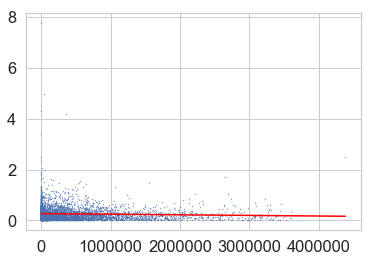

In [170]:
plt.scatter(gdf.NEAR_DIST,gdf.absSlope,s = 0.1)
plt.plot(np.unique(gdf.NEAR_DIST), np.poly1d(np.polyfit(gdf.NEAR_DIST, gdf.absSlope, 1))(np.unique(gdf.NEAR_DIST)),
        color = 'red')

In [63]:
gdf_withTrends = gdf[gdf["trend"]!="Zero"]

In [70]:
gdf_withTrends.head()

,stationNum,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,trend,NEAR_FID,NEAR_DIST,geometry,absSlope
2,627720-99999,0.568966,0.263553,0.874378,1.0,345.0,360.0,381.0,13.167,32.667,Positive,1,8.029994e+05,POINT (3636473.8057 1478818.0788),0.568966
3,162440-99999,0.385331,0.201100,0.569562,1.0,188.0,183.0,181.0,41.633,13.300,Positive,1,5.012814e+04,POINT (1480549.227600001 5106162.174800001),0.385331
5,238910-99999,-0.235632,-0.371496,-0.099769,-1.0,231.0,275.0,262.0,61.667,96.367,Negative,1,2.467069e+06,POINT (10727525.3693 8780610.964299999),0.235632
6,616790-99999,0.229064,0.065411,0.392717,1.0,321.0,339.0,7.9,14.147,-16.051,Positive,1,3.500636e+04,POINT (-1786789.146699999 1591086.888599999),0.229064
7,266290-99999,-0.257526,-0.363426,-0.151626,-1.0,231.0,232.0,77.0,54.883,23.833,Negative,1,2.886691e+05,POINT (2653077.4241 7339191.829599999),0.257526


In [77]:
gdf_withTrends = gdf_withTrends.reset_index(drop=True)

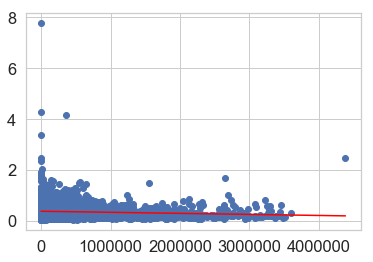

In [78]:
plt.scatter(gdf_withTrends.NEAR_DIST,gdf_withTrends.absSlope)
plt.plot(np.unique(gdf_withTrends.NEAR_DIST), np.poly1d(np.polyfit(gdf_withTrends.NEAR_DIST, gdf_withTrends.absSlope, 1))(np.unique(gdf_withTrends.NEAR_DIST)),
        color = 'red')

In [108]:
gdf_withSigTrends = gdf_withTrends[gdf_withTrends["absSlope"]>0.5].reset_index(drop=True)

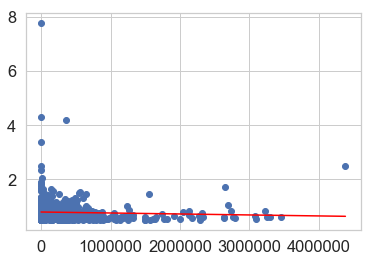

In [109]:
plt.scatter(gdf_withSigTrends.NEAR_DIST,gdf_withSigTrends.absSlope)
plt.plot(np.unique(gdf_withSigTrends.NEAR_DIST), np.poly1d(np.polyfit(gdf_withSigTrends.NEAR_DIST, gdf_withSigTrends.absSlope, 1))(np.unique(gdf_withSigTrends.NEAR_DIST)),
        color = 'red')

In [106]:
1000000/1000

1000.0

In [110]:
gdf_withTrends_1000 = gdf_withTrends[gdf_withTrends.NEAR_DIST<1000000]

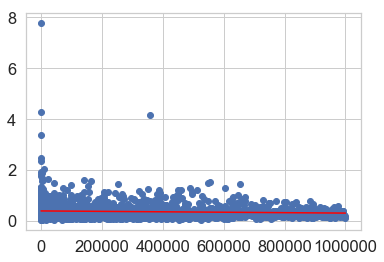

In [111]:
plt.scatter(gdf_withTrends_1000.NEAR_DIST,gdf_withTrends_1000.absSlope)
plt.plot(np.unique(gdf_withTrends_1000.NEAR_DIST), np.poly1d(np.polyfit(gdf_withTrends_1000.NEAR_DIST, gdf_withTrends_1000.absSlope, 1))(np.unique(gdf_withTrends_1000.NEAR_DIST)),
        color = 'red')

In [120]:
gdf_withSigTrends_1000 = gdf_withTrends_1000[gdf_withTrends_1000["absSlope"]>1.5].reset_index(drop=True)

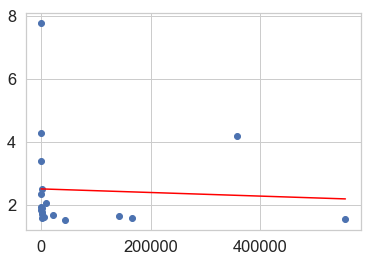

In [121]:
plt.scatter(gdf_withSigTrends_1000.NEAR_DIST,gdf_withSigTrends_1000.absSlope)
plt.plot(np.unique(gdf_withSigTrends_1000.NEAR_DIST), np.poly1d(np.polyfit(gdf_withSigTrends_1000.NEAR_DIST, gdf_withSigTrends_1000.absSlope, 1))(np.unique(gdf_withSigTrends_1000.NEAR_DIST)),
        color = 'red')

In [163]:
sampleGDF= gpd.GeoDataFrame()
for s in np.linspace(0,2,1000):
    gdf1 = gdf[gdf.absSlope>s].sample(1)
    sampleGDF = sampleGDF.append(gdf1,ignore_index=True)
    
#     print(s)
# print(sampleGDF_list)
# sampleGDF = gpd.GeoDataFrame(sampleGDF_list)
#sampleGDF

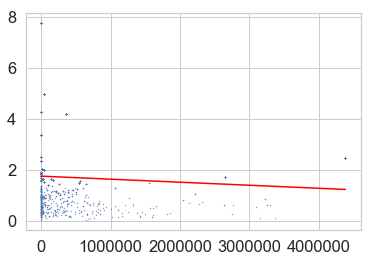

In [169]:
plt.scatter(sampleGDF.NEAR_DIST,sampleGDF.absSlope,s=0.1)
plt.plot(np.unique(sampleGDF.NEAR_DIST), np.poly1d(np.polyfit(sampleGDF.NEAR_DIST, sampleGDF.absSlope, 1))(np.unique(sampleGDF.NEAR_DIST)),
        color = 'red')

Text(0.5, 1.0, 'absolute slope')

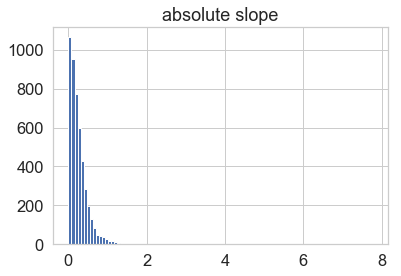

In [175]:
plt.hist(gdf.absSlope,100);
plt.title("absolute slope")

Text(0.5, 1.0, 'distance to ocean')

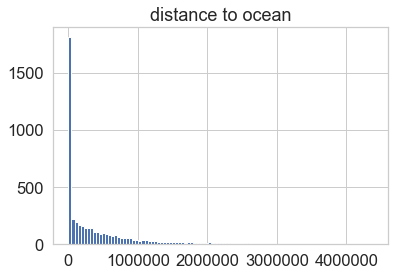

In [176]:
plt.hist(gdf.NEAR_DIST,100);
plt.title("distance to ocean")

# open the cluster data -still need to get better column names

In [365]:
# os.getcwd()

In [278]:
# clusterGDF = gpd.read_file("/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/cluster/stationPoints90_OptimizedHot1.shp")

In [282]:
# clusterGDF.columns.values

array(['stationPoi', 'stationP_1', 'stationP_2', 'stationP_3',
       'stationP_4', 'stationP_5', 'stationP_6', 'stationP_7',
       'stationP_8', 'stationP_9', 'station_10', 'station_11',
       'station_12', 'station_13', 'station_14', 'station_15',
       'station_16', 'station_17', 'station_18', 'station_19', 'geometry'],
      dtype=object)

# Make a wind map

In [82]:
gdf.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,meanWind,mw1990,mw2017,pw1990,pw2017,pwDiff,elev,lat,lon,coordinates,trend
0,239290-99999,0.098522,-0.028054,0.225099,0,26.928571,30.0,30.0,227.0,228.0,1.0,53.0,60.317,64.217,POINT (7148603.740271651 8470655.151552135),Zero
1,485680-99999,0.061576,-0.162410,0.285563,0,18.464286,26.0,22.0,94.0,81.0,13.0,3.7,7.187,100.608,POINT (11199631.32972967 802159.5298121886),Zero
2,916970-99999,-0.726601,-1.151272,-0.301930,-1,27.321429,24.0,1.0,117.0,120.0,3.0,5.0,-19.133,179.750,POINT (20009678.47009093 -2170600.785084128),Negative
3,917530-99999,-0.180624,-0.280164,-0.081084,-1,36.500000,42.0,34.0,108.0,110.0,2.0,24.1,-13.238,-176.199,POINT (-19614382.95828401 -1486936.337375824),Negative
4,601270-99999,0.148878,0.021917,0.275839,1,13.714286,11.0,11.0,270.0,90.0,180.0,510.0,34.217,-4.000,POINT (-445277.9631730949 4057977.175470298),Positive


In [83]:
# windMap = gdf[["stationNumber","coordinates","lat","lon","pw1990","meanWind"]]

In [84]:
# windMap.head()

In [85]:
gdf["meanWind"] = gdf["meanWind"]/10
gdf["mw1990"] = gdf["mw1990"]/10
gdf["mw2017"] = gdf["mw2017"]/10
gdf.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,meanWind,mw1990,mw2017,pw1990,pw2017,pwDiff,elev,lat,lon,coordinates,trend
0,239290-99999,0.098522,-0.028054,0.225099,0,2.692857,3.0,3.0,227.0,228.0,1.0,53.0,60.317,64.217,POINT (7148603.740271651 8470655.151552135),Zero
1,485680-99999,0.061576,-0.162410,0.285563,0,1.846429,2.6,2.2,94.0,81.0,13.0,3.7,7.187,100.608,POINT (11199631.32972967 802159.5298121886),Zero
2,916970-99999,-0.726601,-1.151272,-0.301930,-1,2.732143,2.4,0.1,117.0,120.0,3.0,5.0,-19.133,179.750,POINT (20009678.47009093 -2170600.785084128),Negative
3,917530-99999,-0.180624,-0.280164,-0.081084,-1,3.650000,4.2,3.4,108.0,110.0,2.0,24.1,-13.238,-176.199,POINT (-19614382.95828401 -1486936.337375824),Negative
4,601270-99999,0.148878,0.021917,0.275839,1,1.371429,1.1,1.1,270.0,90.0,180.0,510.0,34.217,-4.000,POINT (-445277.9631730949 4057977.175470298),Positive


In [86]:
# #code to write geodatabases to shape files
# outPathPoints = os.getcwd()+"/outputShapefiles/stationPoints90.shp"
# outPathBuffer = os.getcwd()+"/outputShapefiles/stationBuffer90_1k.shp"

# gdf.to_file(outPathPoints)
# demGDF.to_file(outPathBuffer)

outpath = os.getcwd()+"/outputShapefiles/windMap90.shp"
gdf.to_file(outpath)

In [122]:
NegSamp = gdfSorted[0:50]
PosSamp = gdfSorted[-51:-1]

In [123]:
len(NegSamp),len(PosSamp)

(50, 50)

In [124]:
NegSamp.head()

,stationNum,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,trend,NEAR_FID,NEAR_DIST,geometry
2626,424980-99999,-4.181445,-7.148591,-1.214299,-1.0,25.0,83.0,49.0,25.233,86.950,Negative,1,357996.190606,POINT (9679229.7245 2904390.672600001)
3416,060090-99999,-2.489600,-3.993700,-0.985501,-1.0,243.0,0.0,102.0,61.400,-6.667,Negative,1,1155.652426,POINT (-742167.0450999998 8718253.185599998)
4132,434970-99999,-2.353038,-2.744649,-1.961427,-1.0,59.0,241.0,20.0,6.117,81.133,Negative,1,0.000000,POINT (9031684.2465 682238.5940999985)
2521,766913-99999,-2.048714,-2.609644,-1.487784,-1.0,34.0,19.0,27.4,19.146,-96.187,Negative,1,9225.160792,POINT (-10707487.8609 2172132.613200001)
4532,689200-99999,-1.911604,-2.321692,-1.501515,-1.0,211.0,248.0,14.0,-34.833,20.017,Negative,1,0.000000,POINT (2228282.247200001 -4141209.606199998)


In [125]:
PosSamp.head()

,stationNum,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,trend,NEAR_FID,NEAR_DIST,geometry
3226,760550-99999,0.887794,0.410063,1.365526,1.0,356.0,14.0,15.0,31.033,-114.850,Positive,1,2035.678996,POINT (-12785043.5176 3637035.5634)
2957,947350-99999,0.894636,0.603536,1.185736,1.0,298.0,301.0,845.0,-34.400,149.817,Positive,1,111348.205117,POINT (16677552.1522 -4082639.550000001)
1940,111460-99999,0.896552,0.316232,1.476872,1.0,264.0,318.0,3109.0,47.050,12.950,Positive,1,207217.674654,POINT (1441587.4058 5950239.167000003)
1746,879380-99999,0.899015,0.518674,1.279355,1.0,224.0,258.0,21.6,-54.843,-68.296,Positive,1,0.000000,POINT (-7602675.9432 -7331455.042199999)
4190,943180-99999,0.900657,0.699686,1.101627,1.0,176.0,136.0,112.0,-23.033,115.033,Positive,1,99900.100182,POINT (12805414.9844 -2636009.917399999)


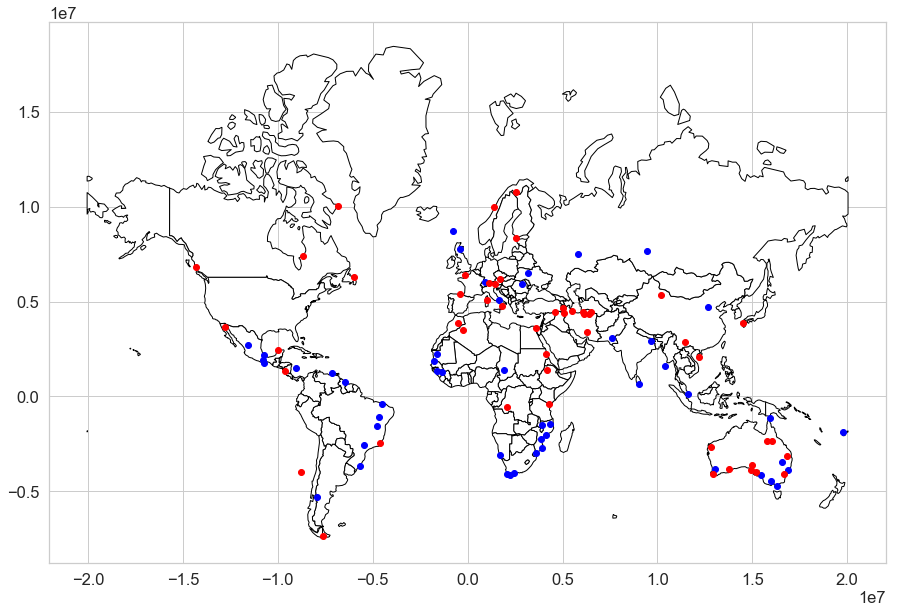

In [126]:
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)
NegSamp.plot(ax = ax,
             color = 'blue')
PosSamp.plot(ax = ax,
             color = 'red')

# Looks like the points are close to the ocean meaning the biggest change in wind speed is occuring close to the ocean

In [97]:
#get the distance to the ocean for the samples that were just taken
negSampDistance = NegSamp["NEAR_DIST"].values
posSampDistance = PosSamp["NEAR_DIST"].values

In [98]:
negSampDistance,posSampDistance

(array([3.57996191e+05, 1.15565243e+03, 0.00000000e+00, 9.22516079e+03,
        0.00000000e+00, 0.00000000e+00, 9.94528846e+02, 2.28571373e+03,
        2.15543934e+04, 1.41936704e+05, 1.65710167e+05, 4.41408648e+04,
        5.49973349e+05, 1.55325280e+06, 9.88641754e+04, 1.54829356e+05,
        1.15277907e+03, 0.00000000e+00, 4.90375181e+05, 6.03687433e+05,
        7.23749383e+04, 4.79108861e+03, 0.00000000e+00, 5.11115153e+05,
        4.50684340e+05, 3.87749348e+05, 0.00000000e+00, 2.63530429e+03,
        1.58328619e+05, 1.39803719e+05, 4.93084259e+03, 2.20556508e+05,
        1.37558081e+03, 1.17369616e+04, 1.80422421e+03, 2.43106554e+05,
        1.04412995e+04, 3.31161963e+05, 0.00000000e+00, 2.20464514e+03,
        2.66734492e+05, 4.50899718e+05, 4.96914999e+05, 2.69256913e+06,
        9.77001858e+04, 7.36427109e+04, 3.63269108e+03, 1.23358836e+06,
        2.07874763e+05, 2.05069326e+03, 2.67802086e+05, 4.28543401e+03,
        4.43747852e+05, 5.29089950e+05, 1.68917585e+03, 3.329620

In [99]:
sampDistance = np.concatenate((negSampDistance,posSampDistance))

In [100]:
#get the population mean
popMean = gdf["NEAR_DIST"].mean()

In [101]:
stats.ttest_1samp(sampDistance,popMean) #this is a two sample result, so we can split it in half

Ttest_1sampResult(statistic=-0.8426997154187433, pvalue=0.39949722002704924)

# It looks like many of the highest value changes are close to oceans.  Let's add in a oceans shapefile to add to geodataframe a "distance from ocean" feature.  This work was done on arcGIS...

In [56]:
oceans = gpd.read_file("/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/ne_10m_ocean/ne_10m_ocean.shp")

In [127]:
oceans = oceans.to_crs(gdf.crs)
oceans.crs

{'init': 'epsg:3857'}

In [131]:
oceans

,featurecla,scalerank,min_zoom,geometry
0,Ocean,0,0,(POLYGON ((6669821.531170589 -10271108.1804419...


In [132]:
oceans.shape

(1, 4)

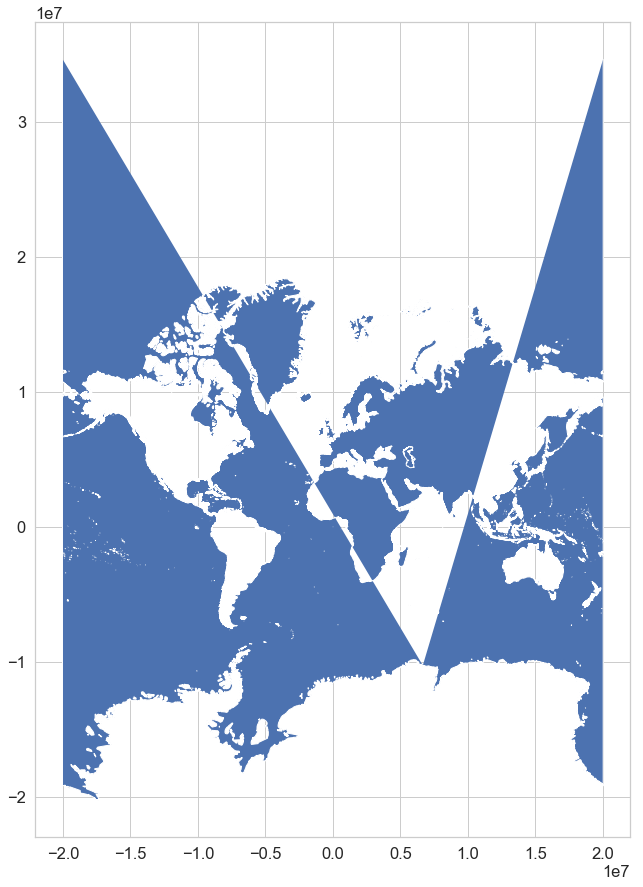

In [148]:
fig,ax = plt.subplots(figsize=(15,15))
oceans.plot(ax = ax)

In [149]:
g = gpd.read_file("/Users/andymetcalf/Desktop/myShape/near.shp")

,stationNum,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon,trend,NEAR_FID,NEAR_DIST,geometry
0,483570-99999,-0.134197,-0.185880,-0.082513,-1.0,135.0,74.0,148.0,17.417,104.783,Negative,1,172286.432807,POINT (11664390.2038 1969420.8046)
1,722310-12916,-0.083380,-0.148009,-0.018750,-1.0,78.0,121.0,1.2,29.998,-90.278,Negative,1,7367.883688,POINT (-10049700.9898 3503292.764600001)
2,702710-26425,-0.092815,-0.161811,-0.023820,-1.0,190.0,157.0,476.1,62.159,-145.459,Negative,1,258204.391502,POINT (-16192421.8113 8896943.113799997)
3,948420-99999,-0.286895,-0.391642,-0.182148,-1.0,287.0,292.0,83.0,-38.850,143.517,Negative,1,0.000000,POINT (15976239.3602 -4700208.078400001)
4,943320-99999,0.347579,0.278563,0.416596,1.0,119.0,131.0,341.7,-20.664,139.489,Positive,1,353277.696067,POINT (15527844.4513 -2351858.9758)


In [133]:
def distance(point,polygon):
    return point.distance(polygon).min()


In [137]:
gdf.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1990,pw2017,elev,lat,lon,coordinates,trend
0,010280-99999,0.119321,-0.326645,0.565288,0,107.0,45.0,18.0,74.517,19.017,POINT (2116962.756415684 12727700.69858087),Zero
1,605810-99999,0.067597,-0.174756,0.309950,0,35.0,27.0,141.1,31.673,6.140,POINT (683501.6734706997 3720462.921176274),Zero
2,627720-99999,0.568966,0.263553,0.874378,1,345.0,360.0,381.0,13.167,32.667,POINT (3636473.805743868 1478818.078774064),Positive
3,162440-99999,0.385331,0.201100,0.569562,1,188.0,183.0,181.0,41.633,13.300,POINT (1480549.227550537 5106162.174793185),Positive
4,722085-93831,-0.087028,-0.195216,0.021161,0,189.0,253.0,11.3,32.483,-80.717,POINT (-8985375.338360664 3826880.213806672),Zero


In [147]:
gdf[1:2].geometry.distance(oceans.geometry)

0   NaN
1   NaN
dtype: float64

In [ ]:
def min_distance(point, lines):
    return lines.distance(point).min()

df_points['min_dist_to_lines'] = df_points.geometry.apply(min_distance, df_lines)


# Code below will likely be replicated by ArcGIS and is therefore not organized

In [27]:
#convert the buffer to decimal so that we can call the 
#elevation package to get SRTM DEMs
#the elevation package uses WGS84 epsg:4326
bufferDecimal = buffer.to_crs({'init' :'epsg:4326'})

In [174]:
west, south, east, north = bounds =  bufferDecimal.bounds.loc[0]
east - west #just a test to see if we are in decimals

0.017966305682378447

In [31]:
#output path for the DEM 
outputPath = os.getcwd()+"/SRTM_DEMs/test.tif"

In [33]:
#call to the elevation package
#SRTM1 is the 30m resolution set
elevation.clip(bounds = bounds, output = outputPath, product = 'SRTM1')

In [189]:
with rasterio.open(outputPath) as dem_raster:
    print(dem_raster.meta)
    

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 65, 'height': 62, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.0002777777777777778, 0.0, 104.77375,
       0.0, -0.0002777777777777778, 17.425694444444442)}


In [190]:
#this is a raster reproject function
def reproject_et(inpath, outpath, new_crs):
    dst_crs = new_crs # CRS for web meractor 

    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [191]:
inpath = outputPath
outpath = '/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/SRTM_DEMs/test3857.tif'

In [192]:
reproject_et(inpath = inpath,
            outpath = outpath,
            new_crs ='EPSG:3857')

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 64, 'height': 64, 'count': 1, 'crs': CRS.from_dict(init='epsg:3857'), 'transform': Affine(31.63863967544067, 0.0, 11663360.49850175,
       0.0, -31.63863967544067, 1970435.1971704613)}

BoundingBox(left=11663360.49850175, bottom=1968410.324231233, right=11665385.371440979, top=1970435.1971704613)


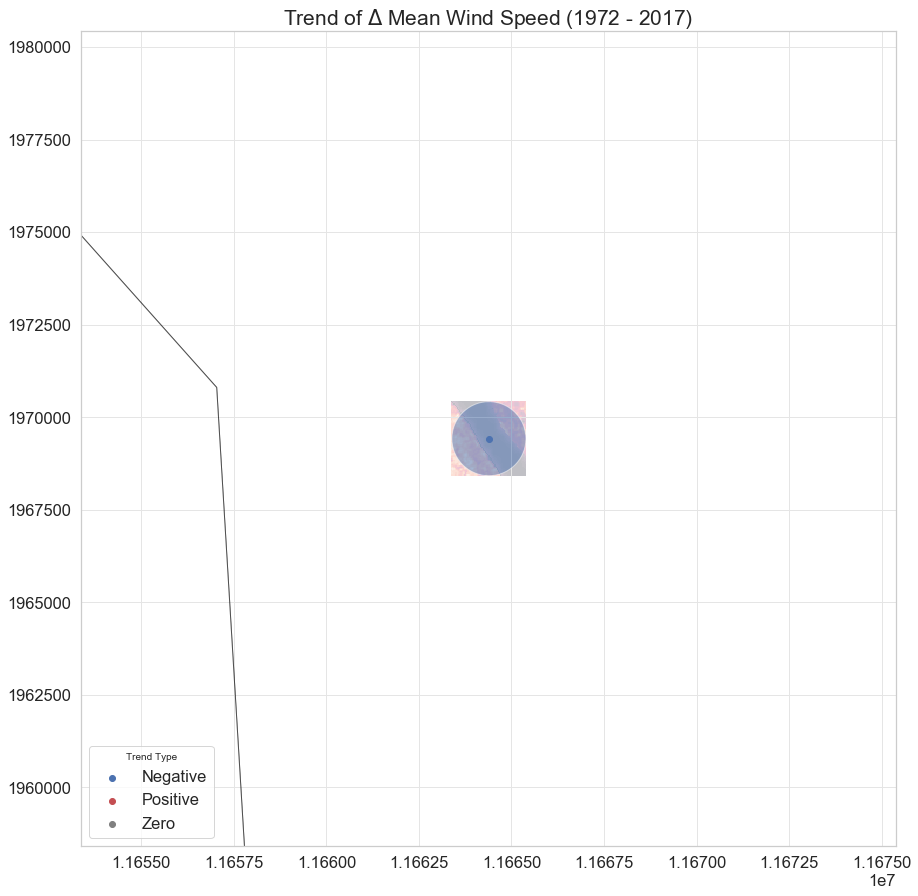

In [193]:
with rasterio.open(outpath) as dem_raster:
    print(dem_raster.meta)
    dem_img = dem_raster.read(1)
    #plot the data
    fig,ax = plt.subplots(figsize=(15,15))
    world.plot(color = 'white',
               edgecolor = 'black',
               ax = ax,
               alpha = 0.5)
    buffer.plot(ax = ax,
               alpha = 0.5)
    show(dem_raster,
         ax=ax,
         alpha = 0.5)

    #loop through each attribute type and plot it using the colors assigned to the dictionary
    for ctype, data in gdf.groupby("trend"):
        color = trendPalette[ctype]
        data.plot(color = color,
                  ax = ax,
                  label = ctype)

    ax.legend(title = "Trend Type",
              loc = "lower left");
    ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);
    print()
    boundsMargin = 10000
    bounds = (dem_raster.bounds[0]-boundsMargin,
              dem_raster.bounds[1]-boundsMargin,
              dem_raster.bounds[2]+boundsMargin,
              dem_raster.bounds[3]+boundsMargin)
    print(dem_raster.bounds)
    ax.set_ylim((dem_raster.bounds[1]-10000,dem_raster.bounds[3]+10000))
    ax.set_xlim((dem_raster.bounds[0]-10000,dem_raster.bounds[2]+10000))

In [74]:
def hillshade(array, azimuth, angle_altitude):

    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.


    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

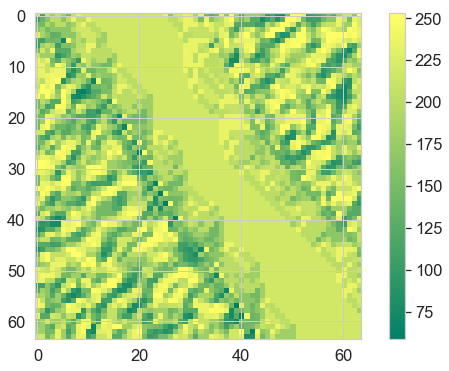

In [96]:
fig, ax = plt.subplots(figsize = (10,6))
hs_array = hillshade(dem_img, 315,45)
plot = ax.imshow(hs_array, cmap='summer');
fig.colorbar(plot);


In [91]:
hs_array

array([[222.51734607, 111.72355184, 208.8540764 , ..., 217.6561146 ,
        166.3540764 , 253.16381636],
       [109.18401273, 138.28025114, 165.94269643, ..., 149.06050229,
        236.3280573 , 225.35258039],
       [149.14506257, 147.49435688, 190.33190818, ..., 179.62821362,
        248.54036969, 224.83877359],
       ...,
       [179.62821362, 179.62821362, 146.1719427 , ..., 217.6561146 ,
        217.6561146 , 217.6561146 ],
       [179.62821362, 179.62821362, 146.1719427 , ..., 217.6561146 ,
        217.6561146 , 217.6561146 ],
       [217.6561146 , 217.6561146 , 146.1719427 , ..., 217.6561146 ,
        217.6561146 , 217.6561146 ]])

In [99]:
def aspect(array):

    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

    x, y = np.gradient(array)
    print(x)
    print()
    print(y)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    print()
    print(slope)
    aspect = np.arctan2(-x, y)
    return aspect

In [100]:
as_array = aspect(dem_img)

[[ 8.  -4.   1.  ...  0.  -1.   1. ]
 [ 4.   1.  -1.5 ... -0.5  0.   0.5]
 [ 1.5  4.5  2.  ... -0.5  1.   0. ]
 ...
 [-0.5  0.   0.  ...  0.   0.   0. ]
 [-0.5 -0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]

[[ 4.   1.5 -0.5 ...  0.   0.5  1. ]
 [-8.  -2.   1.5 ... -0.5  1.   3. ]
 [-2.  -4.  -1.  ...  0.   1.5  2. ]
 ...
 [ 0.  -0.5 -1.  ...  0.   0.   0. ]
 [ 0.   0.  -1.  ...  0.   0.   0. ]
 [ 0.   0.  -1.  ...  0.   0.   0. ]]

[[0.11134101 0.22994211 0.72972766 ... 1.57079633 0.72972766 0.61547971]
 [0.11134101 0.42053434 0.44051066 ... 0.95531662 0.78539816 0.31766319]
 [0.38050638 0.16458848 0.42053434 ... 1.10714872 0.50644464 0.46364761]
 ...
 [1.10714872 1.10714872 0.78539816 ... 1.57079633 1.57079633 1.57079633]
 [1.10714872 1.10714872 0.78539816 ... 1.57079633 1.57079633 1.57079633]
 [1.57079633 1.57079633 0.78539816 ... 1.57079633 1.57079633 1.57079633]]


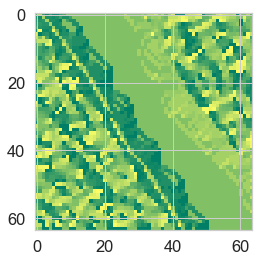

In [88]:
plt.imshow(as_array, cmap='summer')

In [90]:
as_array

array([[-1.10714872,  1.21202566, -2.03444394, ..., -0.        ,
         1.10714872, -0.78539816],
       [-2.67794504, -2.67794504,  0.78539816, ...,  2.35619449,
        -0.        , -0.16514868],
       [-2.49809154, -2.29743867, -2.03444394, ...,  1.57079633,
        -0.5880026 , -0.        ],
       ...,
       [ 1.57079633, -3.14159265, -3.14159265, ..., -0.        ,
        -0.        , -0.        ],
       [ 1.57079633,  1.57079633, -3.14159265, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -3.14159265, ..., -0.        ,
        -0.        , -0.        ]])

In [81]:
vmin = dem_img.min
vmax = dem_img.max

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'builtin_function_or_method'

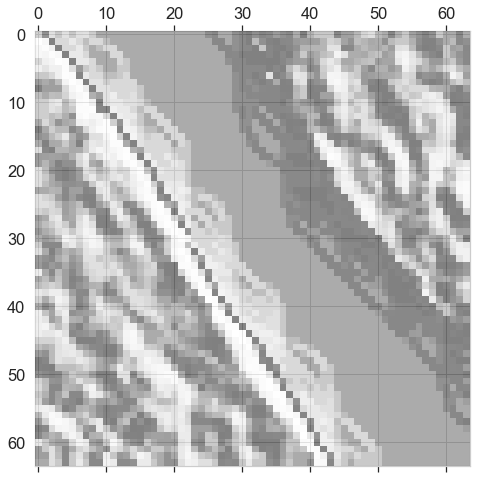

In [82]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.matshow(hillshade(dem_img, 30, 30), cmap='Greys', alpha=.5, zorder=10)
cax = ax.contourf(dem_img, np.arange(vmin, vmax, 10), 
                  cmap=topocmap, vmin=vmin, vmax=vmax, origin='image')
fig.colorbar(cax, ax=ax)
fig.savefig('images/8/2.png')


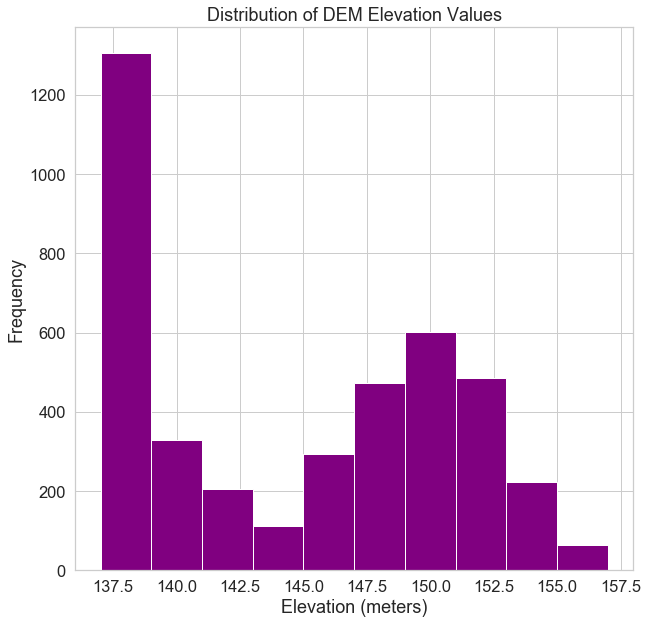

In [41]:
#plot a histogram of the raster elevations
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(dem_img.ravel(), color = 'purple')
ax.set(xlabel = "Elevation (meters)",
      ylabel = "Frequency",
      title = "Distribution of DEM Elevation Values");

RasterioIOError: Dataset is closed: /Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/SRTM_DEMs/test3857.tif

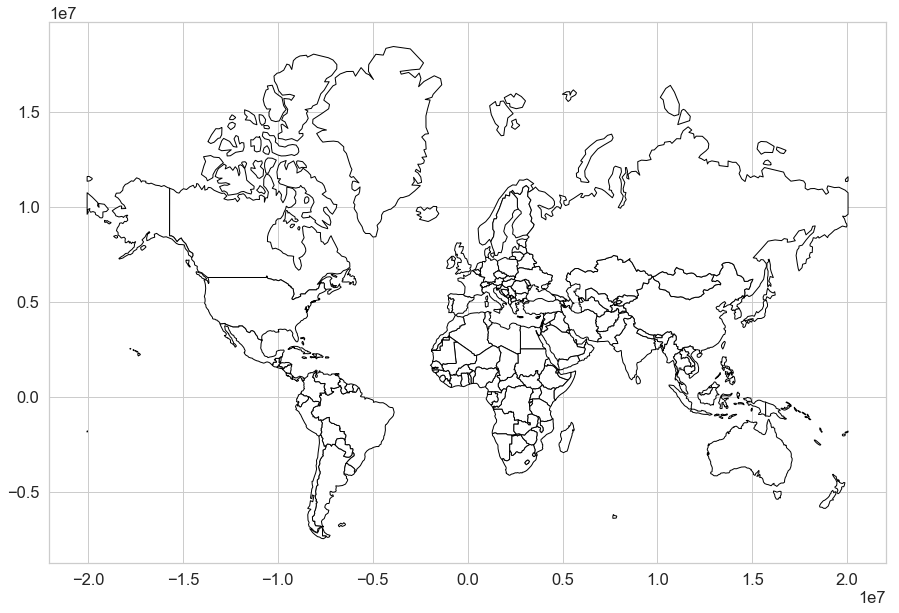

In [42]:
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)
show(dem_raster, ax=ax)

#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype)

ax.legend(title = "Trend Type",
          loc = "lower left");
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);

In [144]:
dem_raster.close()

In [142]:
dem_raster = rasterio.open(output)

In [143]:
dem_raster.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 65,
 'height': 62,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(0.0002777777777777778, 0.0, 104.77375,
        0.0, -0.0002777777777777778, 17.425694444444442)}

In [108]:
buffer.bounds.loc[0].minx

11663390.203791585

In [112]:
dem_raster.bounds

BoundingBox(left=104.77375, bottom=17.40847222222222, right=104.79180555555556, top=17.425694444444442)

In [113]:
pic = dem_raster.read(1)
bounds = (dem_raster.bounds.left,
          dem_raster.bounds.right,
          dem_raster.bounds.bottom,
          dem_raster.bounds.top)

(104.77375, 104.79180555555556)

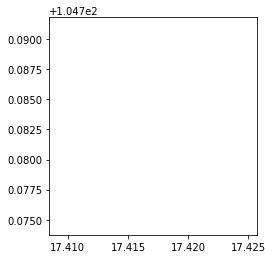

In [138]:
fig, ax = plt.subplots()
world.plot(ax = ax)
buffer.plot(color='r', ax = ax)
ax.imshow(pic, extent = bounds, alpha = 0.5)
ax.set_xlim(bounds[2:4])
ax.set_ylim(bounds[0:2])

In [131]:
bounds[0:2]

(104.77375, 104.79180555555556)

In [85]:
gdf.crs, world.crs, dem_raster.crs

({'init': 'epsg:3857'}, {'init': 'epsg:3857'}, CRS.from_dict(init='epsg:4326'))

In [86]:
bufferDecimal.bounds.loc[0]

minx    104.774017
miny     17.408429
maxx    104.791983
maxy     17.425571
Name: 0, dtype: float64

In [87]:
buffer.bounds.loc[0]

minx    1.166339e+07
miny    1.968421e+06
maxx    1.166539e+07
maxy    1.970421e+06
Name: 0, dtype: float64

In [91]:
src_crs = dem_raster.crs
src_shape = src_height, src_width = dem_raster.shape
src_transform = from_bounds(west, south, east, north, src_width, src_height)
source = dem_raster.read(1)

(62, 65)

In [105]:
dem_raster.close()

In [32]:
import fiona

In [33]:
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [151]:
g = gpd.read_file("/Users/andymetcalf/Desktop/myShape/near.shp")

In [152]:
g.head()

,stationNum,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon,trend,NEAR_FID,NEAR_DIST,geometry
0,483570-99999,-0.134197,-0.185880,-0.082513,-1.0,135.0,74.0,148.0,17.417,104.783,Negative,1,172286.432807,POINT (11664390.2038 1969420.8046)
1,722310-12916,-0.083380,-0.148009,-0.018750,-1.0,78.0,121.0,1.2,29.998,-90.278,Negative,1,7367.883688,POINT (-10049700.9898 3503292.764600001)
2,702710-26425,-0.092815,-0.161811,-0.023820,-1.0,190.0,157.0,476.1,62.159,-145.459,Negative,1,258204.391502,POINT (-16192421.8113 8896943.113799997)
3,948420-99999,-0.286895,-0.391642,-0.182148,-1.0,287.0,292.0,83.0,-38.850,143.517,Negative,1,0.000000,POINT (15976239.3602 -4700208.078400001)
4,943320-99999,0.347579,0.278563,0.416596,1.0,119.0,131.0,341.7,-20.664,139.489,Positive,1,353277.696067,POINT (15527844.4513 -2351858.9758)
